In [65]:
from __future__ import print_function
from data_loader import *
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from  PIL import Image
import numpy as np
import random


In [66]:
######################## FUNCTIONS ########################

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

def get_accuracy(dataloader, net, classes):
    correct = 0
    total = 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(Variable(inputs))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return 100.0 * correct / total

def get_class_accuracy(dataloader, net, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(Variable(inputs))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_perc = []

    for i in range(10):
        class_perc.append(100.0 * class_correct[i] / class_total[i])
    return class_perc



In [67]:
######################## IMPORT DATA ####################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

CIFAR10dir = '/Users/pablo_tostado/Pablo_Tostado/ML_Datasets/CIFAR10'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load Training + Validation
trainloader, validationloader = get_train_valid_loader(data_dir='/datasets/CIFAR-10',
                                                       batch_size=25,
                                                       augment=False,
                                                       random_seed=2)
# Load Testing
testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=25,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


###
# Trsaining: 1800 batches of 25 images (45000 images)
# Validation: 200 batches of 25 images (5000 images)
# Testing: 400 batches of 25 images (10000 images)
###


Files already downloaded and verified
Files already downloaded and verified


In [68]:
####################### VISUALIZE IMAGES ############################################

# trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
#                                           shuffle=True, num_workers=2)


# ##### Print figure with 1 random image from each class
# train_labels = [] # Get labels
# for im in xrange(0, len(trainset)):
#     train_labels.append(trainset[im][1])
# train_labels = np.array(train_labels)

# fig = plt.figure(figsize=(8,3))
# for i in range(10):
#     ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
#     idx = np.where(train_labels==i)     # Find images with target label
#     idx = random.choice(idx[0])         # Pick random idx of current class
#     img = trainset[idx][0] #Take image
#     ax.set_title(classes[i])
#     imshow(img)
# plt.show(block = False)



In [69]:
######################## NET CLASS Example ########################

# conv2(in_channels, out_channels, kernel, stride, padding)
# MaxPool2d(kernel, stride, padding)

class Net_ex(nn.Module):
    def __init__(self):
        super(Net, self).__init__()            # Input: 3x32x32
        self.conv1 = nn.Conv2d(3, 6, 5)        # output = 6x14x14
        self.pool = nn.MaxPool2d(2, 2)      
        self.conv2 = nn.Conv2d(6, 16, 5)       # x = 16x5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # x = 1x120
        self.fc2 = nn.Linear(120, 84)          # x = 1x84
        self.fc3 = nn.Linear(84, 10)           # x = 1x10

    def forward(self, x):                    
        x = self.pool(F.relu(self.conv1(x)))
        print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # tensor.view -> returns a new tensor with the same data, diff dimensions. 
        # If param = -1, dimension inferred from other dimensions.
        x = x.view(-1, 16 * 5 * 5)             # x = 400
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [70]:
######################## NET CLASS 1 ########################

# conv2(in_channels, out_channels, kernel, stride, padding)
# MaxPool2d(kernel, stride, padding)

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()            # Input: 3x32x32
        self.conv1 = nn.Conv2d(3, 64, 3, padding=2)        # output = 64x34x34
        self.conv2 = nn.Conv2d(64, 128, 3, padding=2)        # output = 128x36x36
        self.conv3 = nn.Conv2d(128, 128, 3, padding=2)        # output(after pool) = 128x19x19
        self.pool = nn.MaxPool2d(2, stride=2)      
        self.conv5 = nn.Conv2d(128, 64, 5)       # x = 64x6x6
        self.fc1 = nn.Linear(64 * 6 * 6, 64)  # x = 1x64
        self.fc2 = nn.Linear(64, 128)          # x = 1x128
        self.fc3 = nn.Linear(128, 10)           # x = 1x10

    def forward(self, x):               
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv5(x))
#         print(x.size())
#         print(x.size(0))
        x_size = x.size(0)  #Batch_size (check size to design fc1 accordingly)
        x = x.view(x_size, -1)             
#         print(x.size())
        x = F.relu(self.fc1(x))
#         print(x.size())
        x = F.relu(self.fc2(x))
#         print(x.size())
        x = self.fc3(x)
#         print(x.size())
        return x

In [71]:
####################### RUN NET ###################################

net = Net1()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs = 10
print('Defined Everything')


train_accuracy = []
test_accuracy = []
validation_accuracy = []

train_class_accuracy = []
test_class_accuracy = []
validation_class_accuracy = []

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        # inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Completed an Epoch')
    train_accuracy.append(get_accuracy(trainloader, net, classes))
    test_accuracy.append(get_accuracy(testloader, net, classes))
    validation_accuracy.append(get_accuracy(validationloader, net, classes))

    train_class_accuracy.append(get_class_accuracy(trainloader, net, classes))
    test_class_accuracy.append(get_class_accuracy(testloader, net, classes))
    validation_class_accuracy.append(get_class_accuracy(validationloader, net, classes))
    
print('test accuracy:\n')
print(get_accuracy(testloader, net, classes))

print('validation accuracy:\n')
print(get_accuracy(validationloader, net, classes))


Defined Everything
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
Completed an Epoch
test accuracy:

53.66
validation accuracy:

73.48


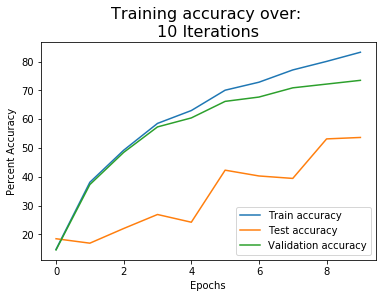

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4


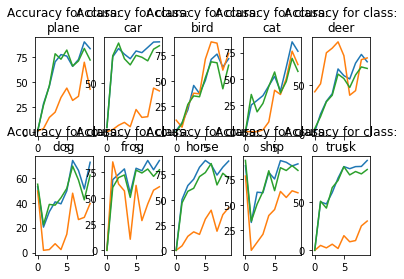

In [72]:
'''
Plotting
'''

'''
Total accuracy
'''
plt.figure()
plt.plot(range(epochs), train_accuracy, label='Train accuracy')
plt.plot(range(epochs), test_accuracy, label='Test accuracy')
plt.plot(range(epochs), validation_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Percent Accuracy')
plt.title('Training accuracy over: \n{} Iterations'.format(epochs), fontsize=16)
plt.legend(loc='lower right')
plt.show(block=False)



'''
Accuracy by class.
'''
plt.figure()
f, axarr = plt.subplots(2, 5)
for i in range(len(classes)):
    if int((i) / 5) > 0:
        row = 1
        col = i % 5
    else:
        row = 0
        col = i

    print(row, col)
    axarr[row, col].plot(range(epochs), list(np.array(train_class_accuracy)[:, i]), label='Train accuracy')
    axarr[row, col].plot(range(epochs), list(np.array(test_class_accuracy)[:, i]), label='Test accuracy')
    axarr[row, col].plot(range(epochs), list(np.array(validation_class_accuracy)[:, i]), label='Validation accuracy')
    axarr[row, col].set_title('Accuracy for class:\n{}'.format(classes[i]))

# # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1:]], visible=False)
plt.show(block=False)